<a href="https://colab.research.google.com/github/Kate-Strydom/cse450/blob/main/Standford_Car_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
"""The stanford car dataset is a 1.86GB file. It may take 25-30 min to download
the entire dataset. If you want to test the notebook with a small dataset, 
you can stop the download after it has downloaded 10-15MB of data. 
Just hit the 'Stop cell' button to the left.

Stanford car dataset: https://ai.stanford.edu/~jkrause/cars/car_dataset.html
"""
# Download the stanford car dataset
!wget http://imagenet.stanford.edu/internal/car196/car_ims.tgz -P stanford-car-classification/data
!wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat -P stanford-car-classification/data
!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz -P stanford-car-classification/data

--2022-07-15 08:55:32--  http://imagenet.stanford.edu/internal/car196/car_ims.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://image-net.org/internal/car196/car_ims.tgz [following]
--2022-07-15 08:55:32--  https://image-net.org/internal/car196/car_ims.tgz
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-15 08:55:33 ERROR 404: Not Found.

--2022-07-15 08:55:33--  http://imagenet.stanford.edu/internal/car196/cars_annos.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Locatio

In [ ]:
# Check if you have the three files downloaded: car_devkit.tgz, car_ims.tgz and cars_annos.mat
!ls -la stanford-car-classification/data

total 468308
drwxr-xr-x 2 root root      4096 Mar  6 02:10 .
drwxr-xr-x 3 root root      4096 Mar  6 02:09 ..
-rw-r--r-- 1 root root    330960 Dec 14  2013 car_devkit.tgz
-rw-r--r-- 1 root root 478804864 Mar  6 02:10 car_ims.tgz
-rw-r--r-- 1 root root    394471 Mar  1  2015 cars_annos.mat


In [ ]:
# Unzip the files
!tar -C stanford-car-classification/data -xzvf stanford-car-classification/data/car_ims.tgz
!tar -C stanford-car-classification/data -xzvf stanford-car-classification/data/car_devkit.tgz

# Only keep the meta file in the devkit
!mv ./stanford-car-classification/data/devkit/cars_meta.mat ./stanford-car-classification/data
!rm -r ./stanford-car-classification/data/devkit

car_ims/
car_ims/011348.jpg
car_ims/014416.jpg
car_ims/014864.jpg
car_ims/006611.jpg
car_ims/015256.jpg
car_ims/010508.jpg
car_ims/015983.jpg
car_ims/007051.jpg
car_ims/008684.jpg
car_ims/008123.jpg
car_ims/004144.jpg
car_ims/005704.jpg
car_ims/012988.jpg
car_ims/009763.jpg
car_ims/010169.jpg
car_ims/015637.jpg
car_ims/007397.jpg
car_ims/015190.jpg
car_ims/007842.jpg
car_ims/007430.jpg
car_ims/003289.jpg
car_ims/014077.jpg
car_ims/011729.jpg
car_ims/006270.jpg
car_ims/005365.jpg
car_ims/000849.jpg
car_ims/009302.jpg
car_ims/004282.jpg
car_ims/016085.jpg
car_ims/008930.jpg
car_ims/008542.jpg
car_ims/004525.jpg
car_ims/004957.jpg
car_ims/004253.jpg
car_ims/008234.jpg
car_ims/004986.jpg
car_ims/008593.jpg
car_ims/016054.jpg
car_ims/009806.jpg
car_ims/009474.jpg
car_ims/005413.jpg
car_ims/005861.jpg
car_ims/000898.jpg
car_ims/006974.jpg
car_ims/006506.jpg
car_ims/003258.jpg
car_ims/014701.jpg
car_ims/002418.jpg
car_ims/007346.jpg
car_ims/007893.jpg
car_ims/015141.jpg
car_ims/009015.jpg
car

In [ ]:
# Get list of file names that were downloaded
file_nms = os.listdir("stanford-car-classification/data/car_ims")

# Sample a few images to investigate data augmentation
N_SAMPLES = 10
sample_file_nms = np.random.choice(file_nms, size=N_SAMPLES, replace=False)
sample_file_nms

array(['014013.jpg', '013743.jpg', '006806.jpg', '002085.jpg',
       '002418.jpg', '014303.jpg', '000093.jpg', '014456.jpg',
       '001504.jpg', '003804.jpg'], dtype='<U10')

In [ ]:
# Path to images
img_path = "stanford-car-classification/data/car_ims/"

# Path to annotation files
annots_path = "stanford-car-classification/data/"

In [ ]:
# Load the annotation files
cars_meta = loadmat(annots_path + 'cars_meta.mat')
cars_annos = loadmat(annots_path + 'cars_annos.mat')

In [ ]:
# Load labels
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['Labels'])
labels.head()

,Labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [ ]:
# Prepare the dataframe to be used with ImageDataGenerator
frame = [[i.flat[0] for i in line] for line in cars_annos['annotations'][0]]
columns = ['fname', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 
           'class', 'train_or_test']
df_imgfilenm_lbls = pd.DataFrame(frame, columns=columns)
# Subtract one from the class because python indexing begins from zero
df_imgfilenm_lbls['class'] = df_imgfilenm_lbls['class'] - 1 

# Combine the labels with the train dataset
df_imgfilenm_lbls = df_imgfilenm_lbls.merge(labels, left_on='class', 
                                            right_index=True)
df_imgfilenm_lbls = df_imgfilenm_lbls.sort_index()

# Subset for only class and fname
df_imgfilenm_lbls = df_imgfilenm_lbls[['fname', 'class']]
df_imgfilenm_lbls['fname'] = df_imgfilenm_lbls['fname'].str.split(pat='/',
                                                                  expand=True)[1]
df_imgfilenm_lbls['class'] = df_imgfilenm_lbls['class'].astype('str')
df_imgfilenm_lbls.head()

,fname,class
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
# Sample a few images to investigate data augmentation
df_sample = df_imgfilenm_lbls[df_imgfilenm_lbls['fname']
                              .isin(sample_file_nms)].reset_index(drop=True)
df_sample

,fname,class
0,000093.jpg,1
1,001504.jpg,18
2,002085.jpg,25
3,002418.jpg,29
4,003804.jpg,47
5,006806.jpg,83
6,013743.jpg,166
7,014013.jpg,170
8,014303.jpg,173
9,014456.jpg,175


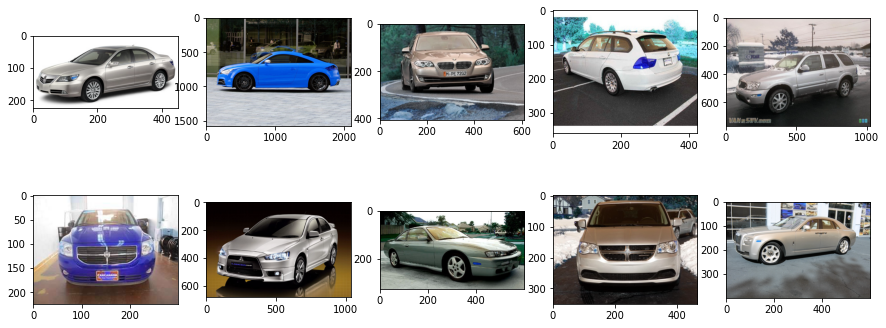

In [ ]:
# Plot the images
N_COLS = 5
n_rows = np.ceil(N_SAMPLES / N_COLS).astype(int)
fig, axes = plt.subplots(n_rows, N_COLS, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = cv2.imread(img_path + df_sample.iloc[i, 0])
    ax.imshow(img)
plt.show()

# Define augmentation steps

In [ ]:
# Folder name that contains the augmented images
aug_img_path = 'stanford-car-classification/data/cars_aug/'

# Create a new folder to save the augmented images
!mkdir -p stanford-car-classification/data/cars_aug/

# Check if the folder was created
!ls -la stanford-car-classification/data/cars_aug

total 8
drwxr-xr-x 2 root root 4096 Mar  6 02:10 .
drwxr-xr-x 4 root root 4096 Mar  6 02:10 ..


In [ ]:
DATA_AUG_BATCH_SIZE = 2  # batch size for data augmentation
img_size = (224, 224)  # input image size to model

# Number of steps to perform data augmentation
n_steps_data_aug = np.ceil(df_sample.shape[0]/DATA_AUG_BATCH_SIZE
                           ).astype(int)

print("Batch size: ", DATA_AUG_BATCH_SIZE)
print("Number of steps: ", n_steps_data_aug)

Batch size:  2
Number of steps:  5


In [ ]:
"""Play around with the values and observe the output images"""
# Image data generator. Transformations to be applied
datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2,  # horizontal shift
    height_shift_range=0.2,  # vertical shift
    zoom_range=0.2, 
    horizontal_flip=True,  
    brightness_range=[0.4, 1.0], 
    fill_mode='nearest') 

# Feed the images to the data generator
aug_gen = datagen.flow_from_dataframe(
    dataframe=df_sample,
    directory=img_path,
    save_to_dir=aug_img_path,
    save_prefix='aug',
    save_format='jpeg',
    x_col="fname",
    y_col="class",
    batch_size=DATA_AUG_BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode="categorical",
    target_size=img_size)
print('Generator created!')

Found 10 validated image filenames belonging to 10 classes.
Generator created!


We will generate a new image for every corresponding image. To do this we will run the image data generator equivalent to the `number of steps` we determined earlier. `Number of steps` is similar to epochs (used for model training).

In [ ]:
"""Run it for longer and observe the difference in the images generated.
"""
# Run the data generator
for i in range(n_steps_data_aug):
    next(aug_gen)

In [ ]:
# Number of augmented images created
aug_file_nm = os.listdir(aug_img_path)
number_files = len(aug_file_nm)
print("Number of new images generated: {}".format(number_files))

Number of new images generated: 10


Original images


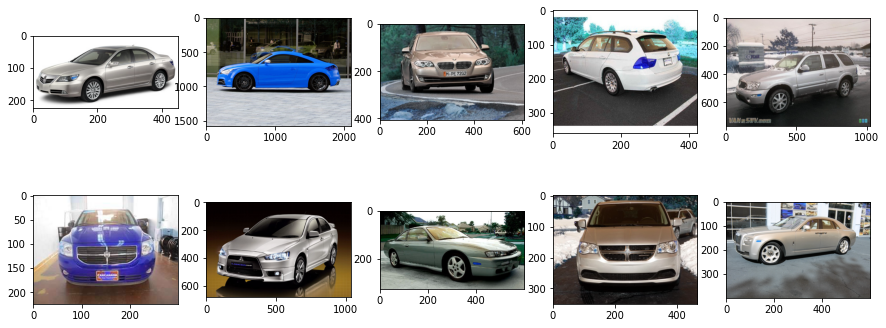


Augmented images


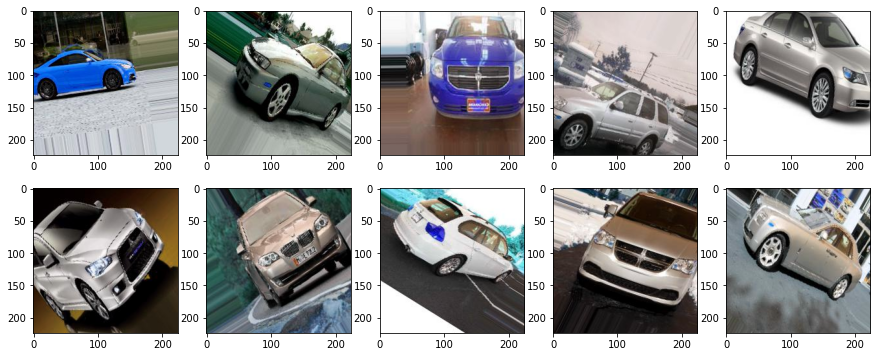

In [ ]:
# Plot the original image samples
print("Original images")
fig, axes = plt.subplots(n_rows, N_COLS, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = cv2.imread(img_path + df_sample.iloc[i, 0])
    ax.imshow(img)
plt.show()

# Plot the augmented images
print("\nAugmented images")
fig, axes = plt.subplots(n_rows, N_COLS, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = cv2.imread(aug_img_path + aug_file_nm[i])
    ax.imshow(img)
plt.show()

# How do we know which image belongs to which class?

The ImageDataGenerator randomly applies the transformations to the images. If you decide to shuffle it becomes difficult to associate the augmented images to the appropriate labels. 

The augmented image file names are generated using the following pattern:

`prefix_idx_randn`

- **prefix:** prefix provided by user
- **idx:** index of data point in the dataframe fed to generator
- **randn:** random number

In [ ]:
# Structure of generated file names
aug_file_nm

['aug_1_5664789.jpeg',
 'aug_7_631054.jpeg',
 'aug_5_6028627.jpeg',
 'aug_4_8351445.jpeg',
 'aug_0_9784633.jpeg',
 'aug_6_5123896.jpeg',
 'aug_2_3921660.jpeg',
 'aug_3_7757856.jpeg',
 'aug_8_8252162.jpeg',
 'aug_9_5698539.jpeg']

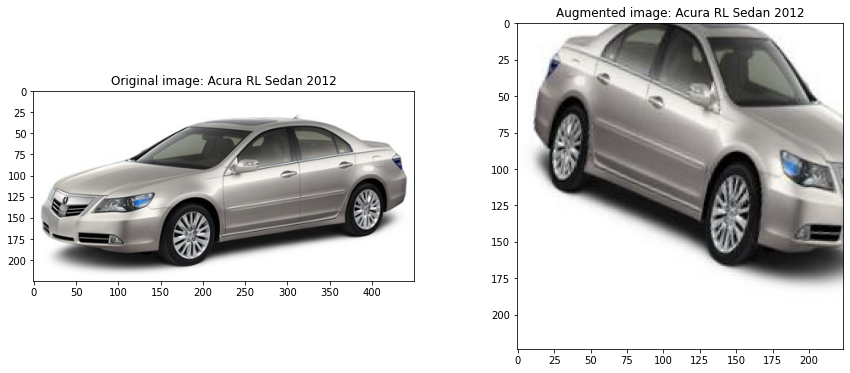

In [ ]:
# Random index from augmented file names
i = np.random.randint(low=0, high=N_SAMPLES, size=1)[0]  

# Get the index from the file name
idx = int(aug_file_nm[i].split('_')[1])

# Get the label of the car
lbl = labels.iloc[int(df_sample.iloc[idx, 1])].values[0]

# Plot the original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# Plot the original image
img = cv2.imread(img_path + df_sample.iloc[idx, 0])
ax[0].title.set_text("Original image: " + lbl)
ax[0].imshow(img)

# Plot the augmented image
img = cv2.imread(aug_img_path + aug_file_nm[i])
ax[1].title.set_text("Augmented image: " + lbl)
ax[1].imshow(img)
plt.show()

In [ ]:
# Remove the folder with the augmented images
# !rm -r stanford-car-classification/data/cars_aug
# !ls -la stanford-car-classification/data/

total 27924
drwxr-xr-x 3 root  root      4096 Mar  6 01:31 .
drwxr-xr-x 3 root  root      4096 Mar  6 00:23 ..
-rw-r--r-- 1 root  root    330960 Dec 14  2013 car_devkit.tgz
drwxr-xr-x 2 10905 users    12288 Mar  1  2015 car_ims
-rw-r--r-- 1 root  root  27839944 Mar  6 00:24 car_ims.tgz
-rw-r--r-- 1 root  root    394471 Mar  1  2015 cars_annos.mat
-rw-r--r-- 1 10905 users     3177 Dec 14  2013 cars_meta.mat
